In [ ]:
"""
This script iterates over all files and checks if we can open them and if the columsn are named correctly
"""

import lzma
from pathlib import Path
from tqdm import tqdm
import shutil
import threading
from typing import Tuple, List


# Helper Functions
def read_header_lines(file_path: Path) -> Tuple[str, str]:
    """Reads the first two lines of the compressed CSV file."""
    with lzma.open(file_path, "rt") as f:
        first_line = f.readline().strip()   # Get Headers
        second_line = f.readline().strip()  # Check for data existence
    return first_line, second_line

def rewrite_file_with_correct_header(file_path: Path, correct_header: str):
    """Rewrites the file with a corrected header and replaces the original."""
    
    #Create a temporary file path to not overwrite the original file while reading
    temp_file = file_path.with_suffix(".tmp") 
    with lzma.open(file_path, "rt") as file_in, lzma.open(temp_file, "wt") as file_out:
        _ = file_in.readline()  # skip old header
        file_out.write(correct_header + "\n")
        shutil.copyfileobj(file_in, file_out)
    temp_file.replace(file_path)

def is_header_correct(file_path: Path, header_line: str) -> bool:
    """Checks if the current header matches the expected format."""
    expected = f"WsDateTime,{file_path.parent.name}"
    return header_line == expected

def handle_thread_result(file_path: Path, result_holder: List[str], renamed_files: List[str], broken_files: List[str]):
    """Analyzes the result after thread join and updates logs/lists."""
    if not result_holder:
        #print(f"⏱️ Timeout: {file_path}")
        broken_files.append(str(file_path))
        return

    result = result_holder[0]
    if result == "ok":
        return
    elif result == "fixed":
        renamed_files.append(str(file_path))
    elif result.startswith("error"):
        #print(f"⚠️ Error with {file_path}: {result}")
        broken_files.append(str(file_path))

def validate_and_fix_header(file_path: Path, result_holder: List[str]):
    """
    Validates and fixes header of a compressed CSV file.
    Appends one of: 'ok', 'fixed', or 'error: ...' to result_holder.
    """
    try:
        first_line, second_line = read_header_lines(file_path)

        if is_header_correct(file_path, first_line):
            result_holder.append("ok")
            return

        expected_header = f"WsDateTime,{file_path.parent.name}"
        rewrite_file_with_correct_header(file_path, expected_header)
        result_holder.append("fixed")

    except Exception as e:
        result_holder.append(f"error: {e}")

def fix_all_headers(base_dir: str, timeout_sec: int = 1) -> Tuple[List[str], List[str]]:
    """
    Loops through all *.csv.xz files under base_dir and validates or corrects headers.
    Uses one thread per file with timeout to avoid hanging on corrupted files.
    """
    base_path = Path(base_dir)
    all_files = list(base_path.rglob("*.csv.xz"))
    print(f"📁 Found {len(all_files)} files to check.\n")

    renamed_files = []
    broken_files = []

    for file_path in tqdm(all_files, desc="Fixing headers", unit="file"):
        result_holder = []

        thread = threading.Thread(target=validate_and_fix_header, args=(file_path, result_holder))
        thread.start()
        thread.join(timeout=timeout_sec)

        handle_thread_result(file_path, result_holder, renamed_files, broken_files)

    print(f"\n✅ Done. Renamed columns in {len(renamed_files)} files.")
    print(f"❌ Skipped or errored in {len(broken_files)} files.")

    return renamed_files, broken_files


if __name__ == "__main__":
    renamed_files, broken_files = fix_all_headers("dataset_clean")


📁 Found 14654 files to check.



Fixing headers: 100%|██████████| 14654/14654 [01:23<00:00, 175.95file/s]


✅ Done. Renamed columns in 0 files.
❌ Skipped or errored in 33 files.


In [4]:
broken_files.append(str("dataset_clean\\EPI_SolderOven\\U12_h19\\2023_U12_h19.csv.xz"))

In [5]:
broken_files

['dataset_clean\\EPI_SolderOven\\U23_h5\\2018_U23_h5.csv.xz',
 'dataset_clean\\EPI_SolderOven\\U3_h19\\2023_U3_h19.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\I2_h29\\2019_I2_h29.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\I3_h13\\2019_I3_h13.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\P2\\2018_P2.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\PF2\\2020_PF2.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\U12_h9\\2022_U12_h9.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\U1_h27\\2019_U1_h27.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\U2_h27\\2019_U2_h27.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\U2_h27\\2020_U2_h27.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\U2_h27\\2021_U2_h27.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\U2_h27\\2022_U2_h27.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\U2_h27\\2023_U2_h27.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\U2_h27\\2024_U2_h27.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\U2_h29\\2018_U2_h29.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\U2_h29\\2019_U2_h29.csv.xz',
 'dataset_clean\\EPI_TotalLoad\\U2_h

In [7]:
"""
This script replaces broken files
"""

import pandas as pd
import lzma
from pathlib import Path
from tqdm import tqdm


def fix_missing_files(missing_files, backup_root="dataset"):
    print(f"📁 Found {len(missing_files)} missing files to fix.\n")

    for i, file_str in enumerate(tqdm(missing_files, desc="Fixing missing files")):
        clean_path = Path(file_str)
        relative_path = clean_path.relative_to("dataset_clean")
        backup_path = Path(backup_root) / relative_path

        if not backup_path.exists():
            print(f"❌ Backup missing: {backup_path}")
            continue

        try:
            measurement = clean_path.parent.name
            year = int(clean_path.stem.split("_")[0])
            print("Measurement: ", measurement, " - Year: ", year)
            # Build 5s time index for the year
            start = pd.Timestamp(f"{year}-01-01 00:00:00")
            end = pd.Timestamp(f"{year}-12-31 23:59:55")
            full_range = pd.date_range(start, end, freq="5s")
            expected_len = len(full_range)

            print(file_str)
            print(f"📏 One year at 5s resolution = {expected_len} rows\n")

            # Read and parse first column as datetime
            with lzma.open(backup_path, "rt") as f:
                df = pd.read_csv(f, parse_dates=[0])
                df.rename(columns={df.columns[0]: "WsDateTime"}, inplace=True)

            # Nearest 5s logic
            df['nearest_5s'] = df['WsDateTime'].dt.round('5s')
            df['abs_diff'] = (df['WsDateTime'] - df['nearest_5s']).abs()

            df_valid = (
                df[df['abs_diff'] <= pd.Timedelta(seconds=5)]
                .sort_values('abs_diff')
                .drop_duplicates('nearest_5s')
                .set_index('nearest_5s')
            )

            # Keep only value column and format output
            value_col = df.columns[1]  # assume 2nd column is the measurement
            df_final = df_valid[[value_col]].reindex(full_range)
            df_final.columns = [measurement]
            df_final.index.name = "WsDateTime"

            # Write back to dataset_clean with correct header
            header = f"WsDateTime,{measurement}"
            clean_path.parent.mkdir(parents=True, exist_ok=True)
            with lzma.open(clean_path, "wt") as f:
                f.write(header + "\n")
                df_final.to_csv(f, header=False)

            # Print result
            print(f"✅ {clean_path.name} | shape={df_final.shape}")
            print(df_final.head(), "\n")

        except Exception as e:
            print(f"⚠️ Error processing {clean_path}: {e}\n")

fix_missing_files(broken_files)

📁 Found 34 missing files to fix.



Fixing missing files:   0%|          | 0/34 [00:00<?, ?it/s]

Measurement:  U23_h5  - Year:  2018
dataset_clean\EPI_SolderOven\U23_h5\2018_U23_h5.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:   3%|▎         | 1/34 [04:55<2:42:29, 295.43s/it]

✅ 2018_U23_h5.csv.xz | shape=(6307200, 1)
                     U23_h5
WsDateTime                 
2018-01-01 00:00:00     1.0
2018-01-01 00:00:05     1.1
2018-01-01 00:00:10     1.0
2018-01-01 00:00:15     1.0
2018-01-01 00:00:20     1.0 

Measurement:  U3_h19  - Year:  2023
dataset_clean\EPI_SolderOven\U3_h19\2023_U3_h19.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:   6%|▌         | 2/34 [09:47<2:36:35, 293.62s/it]

✅ 2023_U3_h19.csv.xz | shape=(6307200, 1)
                     U3_h19
WsDateTime                 
2023-01-01 00:00:00     0.0
2023-01-01 00:00:05     0.0
2023-01-01 00:00:10     NaN
2023-01-01 00:00:15     0.0
2023-01-01 00:00:20     NaN 

Measurement:  I2_h29  - Year:  2019
dataset_clean\EPI_TotalLoad\I2_h29\2019_I2_h29.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:   9%|▉         | 3/34 [14:23<2:27:24, 285.31s/it]

✅ 2019_I2_h29.csv.xz | shape=(6307200, 1)
                     I2_h29
WsDateTime                 
2019-01-01 00:00:00     0.0
2019-01-01 00:00:05     0.0
2019-01-01 00:00:10     1.3
2019-01-01 00:00:15     0.0
2019-01-01 00:00:20     0.0 

Measurement:  I3_h13  - Year:  2019
dataset_clean\EPI_TotalLoad\I3_h13\2019_I3_h13.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  12%|█▏        | 4/34 [18:39<2:16:57, 273.93s/it]

✅ 2019_I3_h13.csv.xz | shape=(6307200, 1)
                     I3_h13
WsDateTime                 
2019-01-01 00:00:00     3.3
2019-01-01 00:00:05     3.9
2019-01-01 00:00:10     3.3
2019-01-01 00:00:15     3.8
2019-01-01 00:00:20     3.2 

Measurement:  P2  - Year:  2018
dataset_clean\EPI_TotalLoad\P2\2018_P2.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  15%|█▍        | 5/34 [23:03<2:10:35, 270.19s/it]

✅ 2018_P2.csv.xz | shape=(6307200, 1)
                       P2
WsDateTime               
2018-01-01 00:00:00  5.33
2018-01-01 00:00:05  6.08
2018-01-01 00:00:10  6.03
2018-01-01 00:00:15  6.01
2018-01-01 00:00:20  6.00 

Measurement:  PF2  - Year:  2020
dataset_clean\EPI_TotalLoad\PF2\2020_PF2.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  18%|█▊        | 6/34 [27:29<2:05:31, 268.97s/it]

✅ 2020_PF2.csv.xz | shape=(6324480, 1)
                     PF2
WsDateTime              
2020-01-01 00:00:00  NaN
2020-01-01 00:00:05  NaN
2020-01-01 00:00:10  NaN
2020-01-01 00:00:15  NaN
2020-01-01 00:00:20  NaN 

Measurement:  U12_h9  - Year:  2022
dataset_clean\EPI_TotalLoad\U12_h9\2022_U12_h9.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  21%|██        | 7/34 [31:53<2:00:11, 267.09s/it]

✅ 2022_U12_h9.csv.xz | shape=(6307200, 1)
                     U12_h9
WsDateTime                 
2022-01-01 00:00:00     0.1
2022-01-01 00:00:05     0.1
2022-01-01 00:00:10     0.1
2022-01-01 00:00:15     NaN
2022-01-01 00:00:20     0.1 

Measurement:  U1_h27  - Year:  2019
dataset_clean\EPI_TotalLoad\U1_h27\2019_U1_h27.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  24%|██▎       | 8/34 [36:45<1:59:10, 275.02s/it]

✅ 2019_U1_h27.csv.xz | shape=(6307200, 1)
                     U1_h27
WsDateTime                 
2019-01-01 00:00:00     0.0
2019-01-01 00:00:05     0.0
2019-01-01 00:00:10     0.0
2019-01-01 00:00:15     0.0
2019-01-01 00:00:20     0.0 

Measurement:  U2_h27  - Year:  2019
dataset_clean\EPI_TotalLoad\U2_h27\2019_U2_h27.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  26%|██▋       | 9/34 [41:37<1:56:47, 280.31s/it]

✅ 2019_U2_h27.csv.xz | shape=(6307200, 1)
                     U2_h27
WsDateTime                 
2019-01-01 00:00:00     0.0
2019-01-01 00:00:05     0.0
2019-01-01 00:00:10     0.0
2019-01-01 00:00:15     0.0
2019-01-01 00:00:20     0.0 

Measurement:  U2_h27  - Year:  2020
dataset_clean\EPI_TotalLoad\U2_h27\2020_U2_h27.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  29%|██▉       | 10/34 [45:30<1:46:17, 265.74s/it]

✅ 2020_U2_h27.csv.xz | shape=(6324480, 1)
                     U2_h27
WsDateTime                 
2020-01-01 00:00:00     NaN
2020-01-01 00:00:05     NaN
2020-01-01 00:00:10     NaN
2020-01-01 00:00:15     NaN
2020-01-01 00:00:20     NaN 

Measurement:  U2_h27  - Year:  2021
dataset_clean\EPI_TotalLoad\U2_h27\2021_U2_h27.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  32%|███▏      | 11/34 [50:11<1:43:43, 270.58s/it]

✅ 2021_U2_h27.csv.xz | shape=(6307200, 1)
                     U2_h27
WsDateTime                 
2021-01-01 00:00:00     NaN
2021-01-01 00:00:05     0.0
2021-01-01 00:00:10     0.0
2021-01-01 00:00:15     0.0
2021-01-01 00:00:20     0.0 

Measurement:  U2_h27  - Year:  2022
dataset_clean\EPI_TotalLoad\U2_h27\2022_U2_h27.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  35%|███▌      | 12/34 [54:48<1:39:55, 272.52s/it]

✅ 2022_U2_h27.csv.xz | shape=(6307200, 1)
                     U2_h27
WsDateTime                 
2022-01-01 00:00:00     0.0
2022-01-01 00:00:05     0.0
2022-01-01 00:00:10     0.0
2022-01-01 00:00:15     NaN
2022-01-01 00:00:20     0.0 

Measurement:  U2_h27  - Year:  2023
dataset_clean\EPI_TotalLoad\U2_h27\2023_U2_h27.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  38%|███▊      | 13/34 [59:40<1:37:28, 278.48s/it]

✅ 2023_U2_h27.csv.xz | shape=(6307200, 1)
                     U2_h27
WsDateTime                 
2023-01-01 00:00:00     0.0
2023-01-01 00:00:05     0.0
2023-01-01 00:00:10     NaN
2023-01-01 00:00:15     0.0
2023-01-01 00:00:20     NaN 

Measurement:  U2_h27  - Year:  2024
dataset_clean\EPI_TotalLoad\U2_h27\2024_U2_h27.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  41%|████      | 14/34 [1:04:32<1:34:10, 282.50s/it]

✅ 2024_U2_h27.csv.xz | shape=(6324480, 1)
                     U2_h27
WsDateTime                 
2024-01-01 00:00:00     NaN
2024-01-01 00:00:05     NaN
2024-01-01 00:00:10     NaN
2024-01-01 00:00:15     NaN
2024-01-01 00:00:20     NaN 

Measurement:  U2_h29  - Year:  2018
dataset_clean\EPI_TotalLoad\U2_h29\2018_U2_h29.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  44%|████▍     | 15/34 [1:08:26<1:24:49, 267.85s/it]

✅ 2018_U2_h29.csv.xz | shape=(6307200, 1)
                     U2_h29
WsDateTime                 
2018-01-01 00:00:00     0.0
2018-01-01 00:00:05     0.0
2018-01-01 00:00:10     0.0
2018-01-01 00:00:15     0.0
2018-01-01 00:00:20     0.0 

Measurement:  U2_h29  - Year:  2019
dataset_clean\EPI_TotalLoad\U2_h29\2019_U2_h29.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  47%|████▋     | 16/34 [1:13:17<1:22:27, 274.87s/it]

✅ 2019_U2_h29.csv.xz | shape=(6307200, 1)
                     U2_h29
WsDateTime                 
2019-01-01 00:00:00     0.0
2019-01-01 00:00:05     0.0
2019-01-01 00:00:10     0.0
2019-01-01 00:00:15     0.0
2019-01-01 00:00:20     0.0 

Measurement:  U2_h3  - Year:  2020
dataset_clean\EPI_TotalLoad\U2_h3\2020_U2_h3.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  50%|█████     | 17/34 [1:18:25<1:20:43, 284.89s/it]

✅ 2020_U2_h3.csv.xz | shape=(6324480, 1)
                     U2_h3
WsDateTime                
2020-01-01 00:00:00    NaN
2020-01-01 00:00:05    NaN
2020-01-01 00:00:10    NaN
2020-01-01 00:00:15    NaN
2020-01-01 00:00:20    NaN 

Measurement:  U2_h31  - Year:  2020
dataset_clean\EPI_TotalLoad\U2_h31\2020_U2_h31.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  53%|█████▎    | 18/34 [1:23:06<1:15:36, 283.51s/it]

✅ 2020_U2_h31.csv.xz | shape=(6324480, 1)
                     U2_h31
WsDateTime                 
2020-01-01 00:00:00     NaN
2020-01-01 00:00:05     NaN
2020-01-01 00:00:10     NaN
2020-01-01 00:00:15     NaN
2020-01-01 00:00:20     NaN 

Measurement:  U31_h11  - Year:  2024
dataset_clean\EPI_TotalLoad\U31_h11\2024_U31_h11.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  56%|█████▌    | 19/34 [1:27:38<1:10:02, 280.15s/it]

✅ 2024_U31_h11.csv.xz | shape=(6324480, 1)
                     U31_h11
WsDateTime                  
2024-01-01 00:00:00      NaN
2024-01-01 00:00:05      NaN
2024-01-01 00:00:10      NaN
2024-01-01 00:00:15      NaN
2024-01-01 00:00:20      NaN 

Measurement:  U31_h25  - Year:  2018
dataset_clean\EPI_TotalLoad\U31_h25\2018_U31_h25.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  59%|█████▉    | 20/34 [1:31:26<1:01:43, 264.54s/it]

✅ 2018_U31_h25.csv.xz | shape=(6307200, 1)
                     U31_h25
WsDateTime                  
2018-01-01 00:00:00      0.0
2018-01-01 00:00:05      0.0
2018-01-01 00:00:10      0.0
2018-01-01 00:00:15      0.0
2018-01-01 00:00:20      0.0 

Measurement:  U_phase_avg  - Year:  2018
dataset_clean\EPI_TotalLoad\U_phase_avg\2018_U_phase_avg.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  62%|██████▏   | 21/34 [1:36:24<59:28, 274.48s/it]  

✅ 2018_U_phase_avg.csv.xz | shape=(6307200, 1)
                     U_phase_avg
WsDateTime                      
2018-01-01 00:00:00       236.77
2018-01-01 00:00:05       236.75
2018-01-01 00:00:10       236.82
2018-01-01 00:00:15       236.80
2018-01-01 00:00:20       236.79 

Measurement:  I1_h11  - Year:  2024
dataset_clean\EPI_VacuumSoldering\I1_h11\2024_I1_h11.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  65%|██████▍   | 22/34 [1:40:31<53:13, 266.15s/it]

✅ 2024_I1_h11.csv.xz | shape=(6324480, 1)
                     I1_h11
WsDateTime                 
2024-01-01 00:00:00     NaN
2024-01-01 00:00:05     NaN
2024-01-01 00:00:10     NaN
2024-01-01 00:00:15     NaN
2024-01-01 00:00:20     NaN 

Measurement:  I1_h21  - Year:  2023
dataset_clean\EPI_VacuumSoldering\I1_h21\2023_I1_h21.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  68%|██████▊   | 23/34 [1:44:47<48:16, 263.34s/it]

✅ 2023_I1_h21.csv.xz | shape=(6307200, 1)
                     I1_h21
WsDateTime                 
2023-01-01 00:00:00     0.0
2023-01-01 00:00:05     0.0
2023-01-01 00:00:10     0.0
2023-01-01 00:00:15     NaN
2023-01-01 00:00:20     NaN 

Measurement:  I1_h25  - Year:  2019
dataset_clean\EPI_VacuumSoldering\I1_h25\2019_I1_h25.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  71%|███████   | 24/34 [1:49:14<44:03, 264.39s/it]

✅ 2019_I1_h25.csv.xz | shape=(6307200, 1)
                     I1_h25
WsDateTime                 
2019-01-01 00:00:00     0.0
2019-01-01 00:00:05     0.0
2019-01-01 00:00:10     0.0
2019-01-01 00:00:15     0.0
2019-01-01 00:00:20     0.0 

Measurement:  I3_h23  - Year:  2024
dataset_clean\EPI_VacuumSoldering\I3_h23\2024_I3_h23.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  74%|███████▎  | 25/34 [1:54:01<40:40, 271.17s/it]

✅ 2024_I3_h23.csv.xz | shape=(6324480, 1)
                     I3_h23
WsDateTime                 
2024-01-01 00:00:00     NaN
2024-01-01 00:00:05     NaN
2024-01-01 00:00:10     NaN
2024-01-01 00:00:15     NaN
2024-01-01 00:00:20     NaN 

Measurement:  I3_h5  - Year:  2018
dataset_clean\EPI_VacuumSoldering\I3_h5\2018_I3_h5.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  76%|███████▋  | 26/34 [1:58:32<36:07, 270.94s/it]

✅ 2018_I3_h5.csv.xz | shape=(6307200, 1)
                     I3_h5
WsDateTime                
2018-01-01 00:00:00    0.0
2018-01-01 00:00:05    0.0
2018-01-01 00:00:10    0.0
2018-01-01 00:00:15    0.0
2018-01-01 00:00:20    0.0 

Measurement:  I3_h5  - Year:  2019
dataset_clean\EPI_VacuumSoldering\I3_h5\2019_I3_h5.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  79%|███████▉  | 27/34 [2:02:19<30:05, 257.97s/it]

✅ 2019_I3_h5.csv.xz | shape=(6307200, 1)
                     I3_h5
WsDateTime                
2019-01-01 00:00:00    0.0
2019-01-01 00:00:05    0.0
2019-01-01 00:00:10    0.0
2019-01-01 00:00:15    0.0
2019-01-01 00:00:20    0.0 

Measurement:  I3_h5  - Year:  2020
dataset_clean\EPI_VacuumSoldering\I3_h5\2020_I3_h5.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  82%|████████▏ | 28/34 [2:06:55<26:20, 263.38s/it]

✅ 2020_I3_h5.csv.xz | shape=(6324480, 1)
                     I3_h5
WsDateTime                
2020-01-01 00:00:00    NaN
2020-01-01 00:00:05    NaN
2020-01-01 00:00:10    NaN
2020-01-01 00:00:15    NaN
2020-01-01 00:00:20    NaN 

Measurement:  I3_h5  - Year:  2022
dataset_clean\EPI_VacuumSoldering\I3_h5\2022_I3_h5.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  85%|████████▌ | 29/34 [2:11:19<21:56, 263.36s/it]

✅ 2022_I3_h5.csv.xz | shape=(6307200, 1)
                     I3_h5
WsDateTime                
2022-01-01 00:00:00    0.0
2022-01-01 00:00:05    0.0
2022-01-01 00:00:10    0.0
2022-01-01 00:00:15    NaN
2022-01-01 00:00:20    0.0 

Measurement:  S_total_vec  - Year:  2018
dataset_clean\EPI_VacuumSoldering\S_total_vec\2018_S_total_vec.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files:  88%|████████▊ | 30/34 [2:15:58<17:52, 268.07s/it]

✅ 2018_S_total_vec.csv.xz | shape=(6307200, 1)
                     S_total_vec
WsDateTime                      
2018-01-01 00:00:00          0.0
2018-01-01 00:00:05          0.0
2018-01-01 00:00:10          0.0
2018-01-01 00:00:15          0.0
2018-01-01 00:00:20          0.0 

Measurement:  THD_U3  - Year:  2020
dataset_clean\EPI_VacuumSoldering\THD_U3\2020_THD_U3.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  91%|█████████ | 31/34 [2:20:49<13:45, 275.11s/it]

✅ 2020_THD_U3.csv.xz | shape=(6324480, 1)
                     THD_U3
WsDateTime                 
2020-01-01 00:00:00     NaN
2020-01-01 00:00:05     NaN
2020-01-01 00:00:10     NaN
2020-01-01 00:00:15     NaN
2020-01-01 00:00:20     NaN 

Measurement:  U1_h3  - Year:  2024
dataset_clean\EPI_VacuumSoldering\U1_h3\2024_U1_h3.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  94%|█████████▍| 32/34 [2:25:08<09:00, 270.24s/it]

✅ 2024_U1_h3.csv.xz | shape=(6324480, 1)
                     U1_h3
WsDateTime                
2024-01-01 00:00:00    NaN
2024-01-01 00:00:05    NaN
2024-01-01 00:00:10    NaN
2024-01-01 00:00:15    NaN
2024-01-01 00:00:20    NaN 

Measurement:  U31_h13  - Year:  2024
dataset_clean\EPI_VacuumSoldering\U31_h13\2024_U31_h13.csv.xz
📏 One year at 5s resolution = 6324480 rows



Fixing missing files:  97%|█████████▋| 33/34 [2:29:57<04:35, 275.74s/it]

✅ 2024_U31_h13.csv.xz | shape=(6324480, 1)
                     U31_h13
WsDateTime                  
2024-01-01 00:00:00      NaN
2024-01-01 00:00:05      NaN
2024-01-01 00:00:10      NaN
2024-01-01 00:00:15      NaN
2024-01-01 00:00:20      NaN 

Measurement:  U12_h19  - Year:  2023
dataset_clean\EPI_SolderOven\U12_h19\2023_U12_h19.csv.xz
📏 One year at 5s resolution = 6307200 rows



Fixing missing files: 100%|██████████| 34/34 [2:34:57<00:00, 273.46s/it]

✅ 2023_U12_h19.csv.xz | shape=(6307200, 1)
                     U12_h19
WsDateTime                  
2023-01-01 00:00:00      0.0
2023-01-01 00:00:05      0.0
2023-01-01 00:00:10      NaN
2023-01-01 00:00:15      0.0
2023-01-01 00:00:20      NaN 



### Create missing and stats files for \dataset_clean_validation

In [1]:
import pandas as pd
import numpy as np
import lzma
from pathlib import Path
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# 1. Compute basic statistics for one time series
def calculate_stats_per_file(series: pd.Series) -> dict:
    return {
        "min": series.min(),
        "max": series.max(),
        "mean": series.mean(),
        "std": series.std(),
        "q01": series.quantile(0.01),
        "q05": series.quantile(0.05),
        "q25": series.quantile(0.25),
        "q50": series.quantile(0.50),
        "q75": series.quantile(0.75),
        "q95": series.quantile(0.95),
        "q99": series.quantile(0.99),
    }

# 2. Analyze missing values and gap durations
def calculate_missing_per_file(series: pd.Series) -> dict:
    result = {
        "n_total": len(series),
        "n_nans": series.isna().sum(),
        "n_zeros": (series == 0).sum(),
    }

    # 2.1 NaNs at start/middle/end
    first_valid = series.first_valid_index()
    last_valid = series.last_valid_index()
    result["n_nans_start"] = series.loc[:first_valid].isna().sum() if first_valid else result["n_nans"]
    result["n_nans_end"] = series.loc[last_valid:].isna().sum() if last_valid else 0
    result["n_nans_middle"] = result["n_nans"] - result["n_nans_start"] - result["n_nans_end"]

    # 2.2 Gap duration buckets
    gap_buckets = [
        ("nan_1_step", 5, 5),
        ("nan_5s_30s", 6, 30),
        ("nan_30s_1m", 31, 60),
        ("nan_1m_15m", 61, 900),
        ("nan_15m_1h", 901, 3600),
        ("nan_1h_24h", 3601, 86400),
        ("nan_1d_7d", 86401, 604800),
        ("nan_1w_1mo", 604801, 2678400),
        ("nan_1mo_inf", 2678401, float("inf")),
    ]

    # Identify missing gaps
    is_missing = series.isna().astype("int")
    diff = is_missing.diff()
    gap_starts = series.index[diff == 1]
    gap_ends = series.index[diff == -1]

    if is_missing.iloc[0] == 1:
        gap_starts = gap_starts.insert(0, series.index[0])
    if is_missing.iloc[-1] == 1:
        gap_ends = gap_ends.append(pd.Index([series.index[-1]]))

    gap_durations = (gap_ends.values - gap_starts.values) / np.timedelta64(1, "s")  # in seconds
    gap_durations = np.array(gap_durations)

    total_gaps = len(gap_durations)
    total_missing_steps = int(gap_durations.sum())

    result["n_missing_gaps"] = total_gaps
    result["missing_gap_total_sec"] = total_missing_steps

    for name, lower, upper in gap_buckets:
        mask = (gap_durations >= lower) & (gap_durations <= upper)
        gap_count = int(mask.sum())
        missing_steps = int(gap_durations[mask].sum())
        pct = round((missing_steps / total_missing_steps * 100), 2) if total_missing_steps > 0 else 0.0

        result[f"{name}_count"] = gap_count
        result[f"{name}_steps"] = missing_steps
        result[f"{name}_pct"] = pct

    return result


# 3. Validate a single file and return stats + missing
def validate_file(file_path: Path) -> tuple[dict, dict] | None:
    try:
        with lzma.open(file_path, "rt") as f:
            df = pd.read_csv(f)

        # Flexible header handling
        df.columns = df.columns.str.strip()
        if "WsDateTime" not in df.columns:
            df.rename(columns={df.columns[0]: "WsDateTime"}, inplace=True)
        if "value" not in df.columns:
            df.rename(columns={df.columns[1]: "value"}, inplace=True)

        df["WsDateTime"] = pd.to_datetime(df["WsDateTime"], errors="coerce")
        df.set_index("WsDateTime", inplace=True)
        df.sort_index(inplace=True)
        series = df["value"]

        stats = calculate_stats_per_file(series.dropna())
        missing = calculate_missing_per_file(series)

        machine = file_path.parts[-3]
        measurement = file_path.parts[-2]
        filename = file_path.stem
        year = filename.split("_")[0]

        meta = {
            "file_path": str(file_path),
        }

        return {**meta, **stats}, {**meta, **missing}

    except Exception as e:
        print(f"⚠️ Error reading {file_path}: {e}")
        return None

# 4. Validate all files and write per-machine/measurement/year results
def validate_dataset(base_dir="dataset_clean", output_dir="validation_results", test_limit=None):
    """Validates all .csv.xz files and writes per-machine/measurement stats/missing files sequentially."""
    base_path = Path(base_dir)
    out_path = Path(output_dir)
    all_files = list(base_path.rglob("*.csv.xz"))

    if test_limit:
        all_files = all_files[:test_limit]
        print(f"🧪 Test mode: validating {len(all_files)} files.\n")
    else:
        print(f"📁 Found {len(all_files)} files to validate.\n")

    # Step 1: Track processed paths for stats and missing separately
    processed_stats = set()
    processed_missing = set()

    for file_path in all_files:
        machine = file_path.parts[-3]
        measurement = file_path.parts[-2]
        year_part = file_path.stem.split("_")[0]

        stats_file = out_path / machine / measurement / f"{year_part}_{measurement}_stats.csv"
        missing_file = out_path / machine / measurement / f"{year_part}_{measurement}_missing.csv"

        if stats_file.exists():
            try:
                processed_stats.update(pd.read_csv(stats_file)["file_path"].dropna())
            except Exception as e:
                print(f"⚠️ Could not read {stats_file}: {e}")
        if missing_file.exists():
            try:
                processed_missing.update(pd.read_csv(missing_file)["file_path"].dropna())
            except Exception as e:
                print(f"⚠️ Could not read {missing_file}: {e}")

    # Step 2: Filter files that need any processing
    all_files = [f for f in all_files if (str(f) not in processed_stats or str(f) not in processed_missing)]

    print(f"🚀 Starting validation of {len(all_files)} new files...\n")

    # Step 3: Validate files sequentially
    for i, file_path in enumerate(all_files, 1):
        print(f"[{i}/{len(all_files)}] 📂 Starting: {file_path}")
        result = validate_file(file_path)
        if result is None:
            print(f"[{i}/{len(all_files)}] ⚠️ Skipped: {file_path} (error or unreadable)")
            continue

        stats_row, missing_row = result
        machine_name = file_path.parts[-3]
        measurement_name = file_path.parts[-2]
        year_part = file_path.stem.split("_")[0]

        stats_file = out_path / machine_name / measurement_name / f"{year_part}_{measurement_name}_stats.csv"
        missing_file = out_path / machine_name / measurement_name / f"{year_part}_{measurement_name}_missing.csv"

        stats_df = pd.DataFrame([stats_row])
        missing_df = pd.DataFrame([missing_row])

        stats_file.parent.mkdir(parents=True, exist_ok=True)
        stats_df.to_csv(stats_file, mode="a", index=False, header=not stats_file.exists())
        missing_df.to_csv(missing_file, mode="a", index=False, header=not missing_file.exists())
        print(f"[{i}/{len(all_files)}] ✅ Done: {file_path}\n")


In [2]:
df_test = validate_dataset(test_limit=None)

📁 Found 14654 files to validate.

🚀 Starting validation of 14654 new files...

[1/14654] 📂 Starting: dataset_clean\EPI_ChipPress\Freq\2018_Freq.csv.xz
[1/14654] ✅ Done: dataset_clean\EPI_ChipPress\Freq\2018_Freq.csv.xz

[2/14654] 📂 Starting: dataset_clean\EPI_ChipPress\Freq\2019_Freq.csv.xz
[2/14654] ✅ Done: dataset_clean\EPI_ChipPress\Freq\2019_Freq.csv.xz

[3/14654] 📂 Starting: dataset_clean\EPI_ChipPress\Freq\2020_Freq.csv.xz
[3/14654] ✅ Done: dataset_clean\EPI_ChipPress\Freq\2020_Freq.csv.xz

[4/14654] 📂 Starting: dataset_clean\EPI_ChipPress\Freq\2021_Freq.csv.xz
[4/14654] ✅ Done: dataset_clean\EPI_ChipPress\Freq\2021_Freq.csv.xz

[5/14654] 📂 Starting: dataset_clean\EPI_ChipPress\Freq\2022_Freq.csv.xz
[5/14654] ✅ Done: dataset_clean\EPI_ChipPress\Freq\2022_Freq.csv.xz

[6/14654] 📂 Starting: dataset_clean\EPI_ChipPress\Freq\2023_Freq.csv.xz
[6/14654] ✅ Done: dataset_clean\EPI_ChipPress\Freq\2023_Freq.csv.xz

[7/14654] 📂 Starting: dataset_clean\EPI_ChipPress\Freq\2024_Freq.csv.xz
[7/

In [30]:
missing = pd.read_csv(r"validation_results\EPI_ChipPress\Freq\2018_Freq_missing.csv")
stats = pd.read_csv(r"validation_results\EPI_ChipPress\Freq\2018_Freq_stats.csv")
data = pd.read_csv(r"dataset_clean\EPI_ChipPress\Freq\2018_Freq.csv.xz")


,Freq
count,5.640235e+06
mean,4.998855e+01
std,2.130075e-02
min,4.983000e+01
25%,4.997000e+01
50%,4.999000e+01
75%,5.000000e+01
max,5.013000e+01


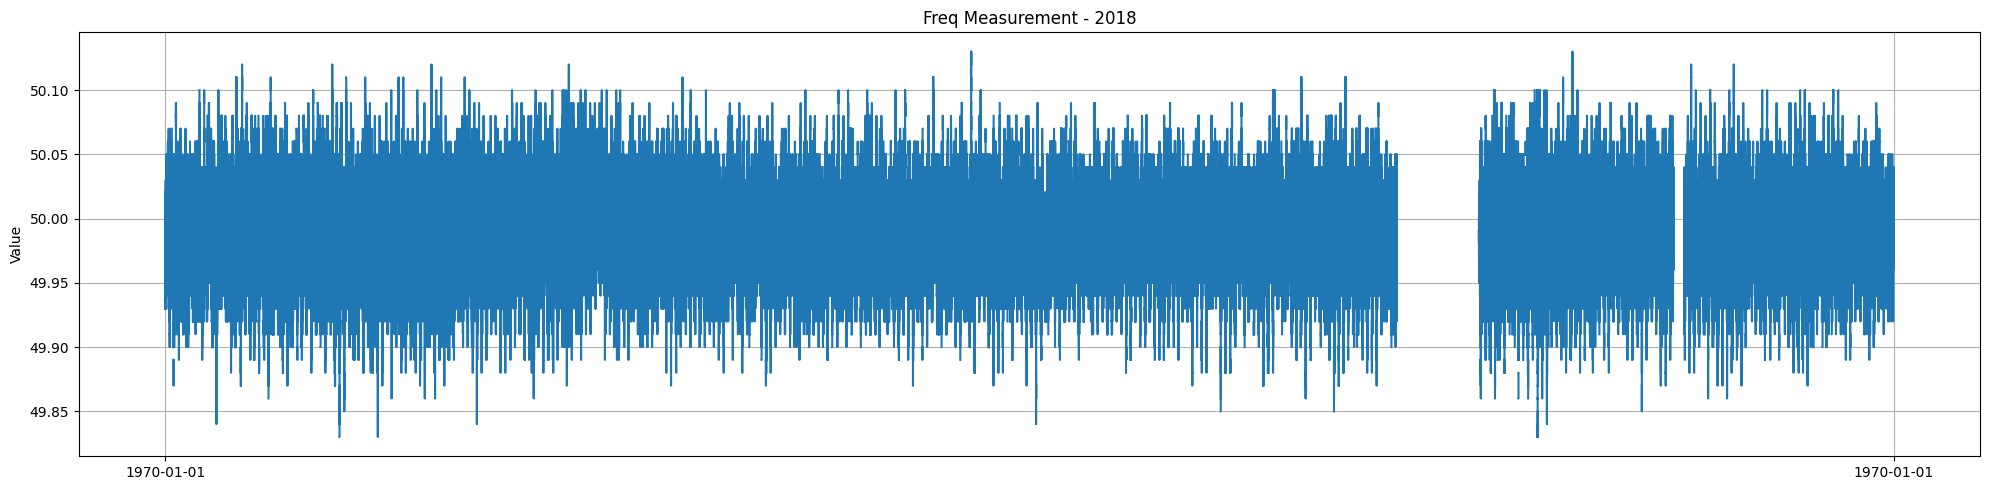

In [31]:
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
import pandas as pd

display(data.describe())

# Ensure datetime index
data.index = pd.to_datetime(data.index)

# Extract second column (the actual measurement)
series = data.iloc[:, 0] if data.shape[1] == 1 else data.iloc[:, 1]

# Plot
plt.figure(figsize=(20, 5))
plt.plot(series)

# Show only the first and last x-ticks
first = series.index[0]
last = series.index[-1]
plt.xticks([first, last], [first.strftime("%Y-%m-%d"), last.strftime("%Y-%m-%d")])

plt.xlabel("")
plt.title("Freq Measurement - 2018")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
with pd.option_context('display.max_columns', 40):
    display(missing)

,file_path,n_total,n_nans,n_zeros,n_nans_start,n_nans_end,n_nans_middle,n_missing_gaps,missing_gap_total_sec,nan_1_step_count,nan_1_step_steps,nan_1_step_pct,nan_5s_30s_count,nan_5s_30s_steps,nan_5s_30s_pct,nan_30s_1m_count,nan_30s_1m_steps,nan_30s_1m_pct,nan_1m_15m_count,nan_1m_15m_steps,nan_1m_15m_pct,nan_15m_1h_count,nan_15m_1h_steps,nan_15m_1h_pct,nan_1h_24h_count,nan_1h_24h_steps,nan_1h_24h_pct,nan_1d_7d_count,nan_1d_7d_steps,nan_1d_7d_pct,nan_1w_1mo_count,nan_1w_1mo_steps,nan_1w_1mo_pct,nan_1mo_inf_count,nan_1mo_inf_steps,nan_1mo_inf_pct
0,dataset_clean\EPI_ChipPress\Freq\2018_Freq.csv.xz,6307200,666965,0,0,719,666246,320844,3334820,320689,1603445,48.08,79,1090,0.03,18,820,0.02,49,7665,0.23,3,6595,0.2,4,18020,0.54,1,198470,5.95,1,1498715,44.94,0,0,0.0
